In [1]:
import numpy as np 
import matplotlib.pyplot as plt
fault_x = np.load("/h1/bhoon/20220725_pix2pix_compare/pana/scaled_FD_X.npy")
fault_y = np.load("/h1/bhoon/20220725_pix2pix_compare/FD_Y.npy")

In [2]:
def show_grid(data,r=4,c=4,jump=1,title='',save='',cmap='gray'):
    plt.figure(figsize=(c*2+1,r*2+1))
    i = 1
    for j in range(0,len(data),jump):
        dat = data[j]
        plt.subplot(r, c, i) 
        plt.imshow(dat, cmap=cmap)
        plt.axis('off')
        i+=1
        if i > r*c: break
    if title:
        plt.suptitle(title)
    if save:
        plt.savefig(save, bbox_inches='tight', pad_inches=0)
        plt.close()
    plt.show()

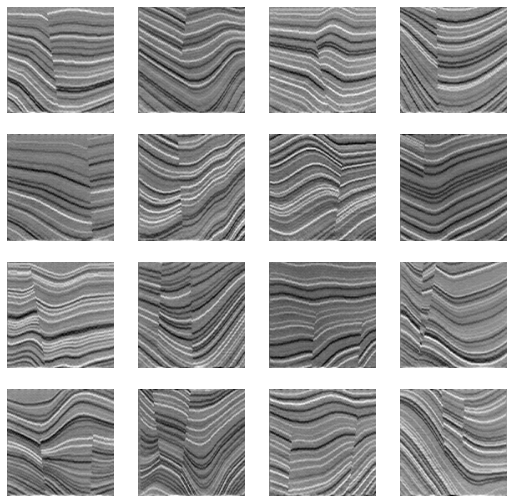

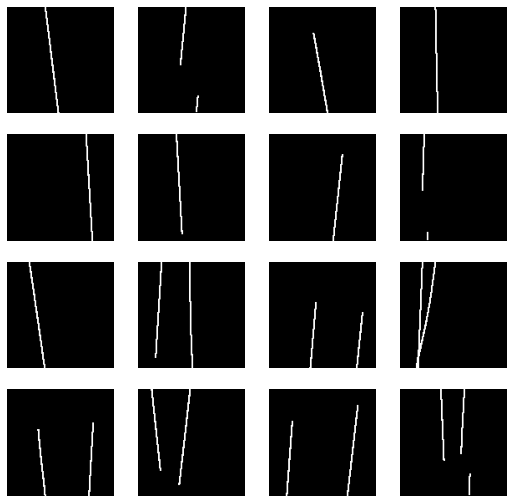

In [3]:
show_grid(fault_x[::135])
show_grid(fault_y[::135])

In [4]:
SPLIT = 5
fdata_idx  = np.arange(len(fault_x))
fvalid_idx = fdata_idx[::SPLIT]
ftrain_idx = np.delete(fdata_idx, fvalid_idx)

trainX = fault_x[ftrain_idx]
validX = fault_x[fvalid_idx]
trainY = fault_y[ftrain_idx]
validY = fault_y[fvalid_idx]

In [5]:
trainX.shape, validX.shape, trainY.shape, validY.shape

((1920, 128, 128, 1), (480, 128, 128, 1), (1920, 128, 128), (480, 128, 128))

In [6]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def unet(pretrained_weights = None,input_size = (None,None,1)):
    inputs = Input(input_size)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
#    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
#    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
#    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
#    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name='enc') (p4)
    c5 = Dropout(0.3) (c5)
#    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
#    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
#    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
#    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
#    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same') (c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/h1/bhoon/20220725_pix2pix_compare/pana/refl.h5",
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min')

In [8]:
model = unet()
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = 'accuracy')

In [9]:
# Model Train
result = model.fit(trainX, trainY,
                   epochs=200,
                   batch_size=32,
                   validation_data=(validX, validY),
                   callbacks=[earlystopper, model_checkpoint])

Epoch 1/200
60/60 [==============================] - 7s 52ms/step - loss: 0.1520 - accuracy: 0.9523 - val_loss: 0.0879 - val_accuracy: 0.9818
Epoch 2/200
60/60 [==============================] - 2s 39ms/step - loss: 0.0746 - accuracy: 0.9825 - val_loss: 0.0537 - val_accuracy: 0.9828
Epoch 3/200
60/60 [==============================] - 2s 39ms/step - loss: 0.0403 - accuracy: 0.9866 - val_loss: 0.0308 - val_accuracy: 0.9885
Epoch 4/200
60/60 [==============================] - 2s 41ms/step - loss: 0.0263 - accuracy: 0.9906 - val_loss: 0.0215 - val_accuracy: 0.9923
Epoch 5/200
60/60 [==============================] - 2s 38ms/step - loss: 0.0219 - accuracy: 0.9921 - val_loss: 0.0190 - val_accuracy: 0.9932
Epoch 6/200
60/60 [==============================] - 2s 37ms/step - loss: 0.0191 - accuracy: 0.9930 - val_loss: 0.0173 - val_accuracy: 0.9939
Epoch 7/200
60/60 [==============================] - 2s 39ms/step - loss: 0.0174 - accuracy: 0.9936 - val_loss: 0.0162 - val_accuracy: 0.9943
Epoch 

In [10]:
def standard_scaler(data):
    scaled = []
    for d in data:
        scaled.append((d - np.mean(d))/np.std(d))
    return np.array(scaled)

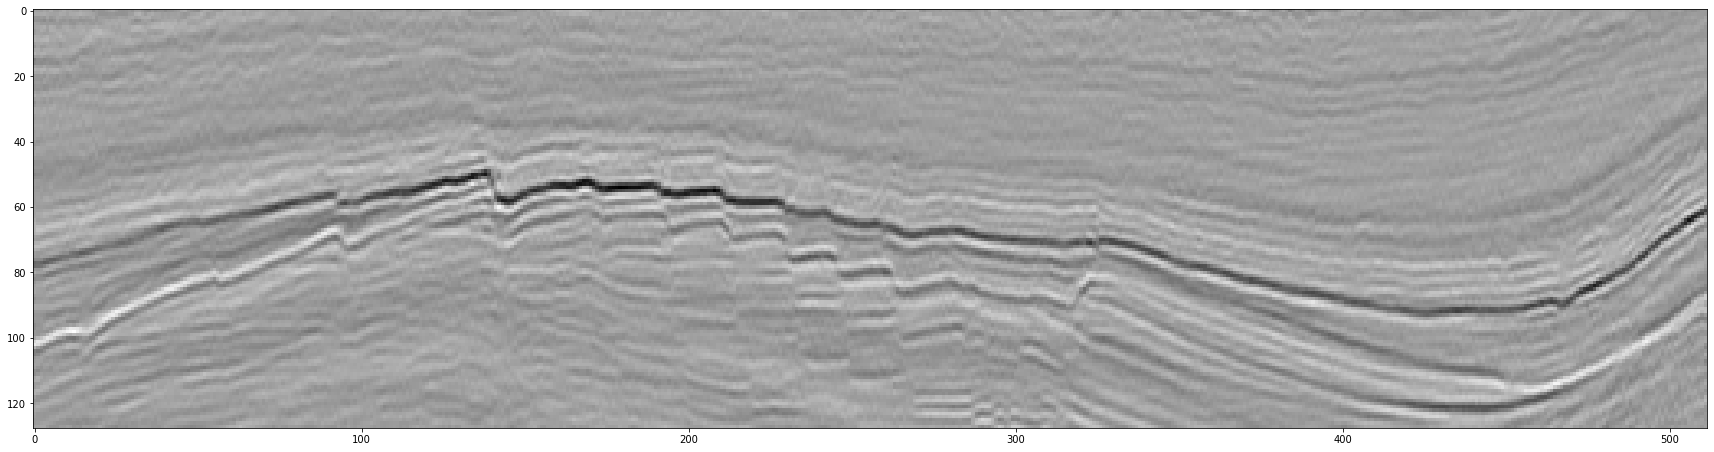

In [11]:
F3path = "/s1/bhoon/dataset/cyclegan_proj/real_f3_data/real_f3_data_raw.npy"
F3 = np.load(F3path).astype(np.float32)
F3 = np.swapaxes(F3,1,2)
F3 = standard_scaler(F3)
plt.figure(figsize=(30,20))
plt.imshow(F3[200],cmap='gray')

In [12]:
F3_pred = np.squeeze(model.predict(F3,batch_size=16))

In [13]:
save_path = '/h1/bhoon/20220725_pix2pix_compare/pana/F3_app/'
try:
    os.mkdir(save_path)
except:
    pass

In [14]:
import cv2
from tqdm import tqdm

for idx in tqdm(range(len(F3_pred))):
    plt.figure(figsize=(30,20))
    plt.imshow(F3[idx],cmap='bwr',aspect='auto')
    plt.axis("off")
    plt.savefig('aaa.jpg', bbox_inches='tight', pad_inches=0)
    plt.close()

    plt.figure(figsize=(30,20))
    plt.imshow(F3_pred[idx],cmap='Greys',aspect='auto')
    plt.axis("off")
    plt.savefig('bbb.jpg', bbox_inches='tight', pad_inches=0)
    plt.close()

    aaa = cv2.imread('aaa.jpg')
    bbb = cv2.imread('bbb.jpg')
    ccc = np.where(bbb<255/2, 0, aaa)
    cv2.imwrite(save_path+"{}.jpg".format(str(idx).zfill(3)),ccc)

100%|██████████| 601/601 [05:53<00:00,  1.70it/s]
